# TAREA DEPP Q LEARNING - CARTPOLE

<b>Autor:</b> Aarón Medina Melián

Importación de las librerías

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gym # for environment
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam # adaptive momentum
import random
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard

Definimos la variable que llamaremos en el callback en el entrenamiento del modelo para poder monitorizar y visualizar métricas del modelo. Esto genera unos archivos en la carpeta logs que luego podremos ver una vez entrenado el modelo

In [2]:
tensorboard_callback = TensorBoard(log_dir="./logs")

<p>En este código definimos el agente de aprendizaje por refuerzo usando Deep Q-Learning con el juego CartPole</p>
<p>La función <i>build_model</i> construye el modelo y define las capas
<p>La función <i>remember</i> guarda las transiciones para un futuro uso
<p>La función <i>act</i> decide si explorar (tomar un acción aleatoria) o usar el modelo para predecir la mejor acción basada en el estado actual dependiendo de un valor de epsilon
<p>La función <i>replay</i> entrena el modelo
<p>La función <i>adaptiveEGreedy</i> ajusta el valor de epsilon después de cada episodio para reducir la exploración a medida que el agente aprende más sobre el entorno

<p>Luego se ejecuta el entrenamiento varios episodios definidos. Durante cada episodio, el agente realiza acciones hasta que el entorno indica que el episodio ha terminado (cuando el palo cae o se alcanza el máximo de pasos), ajustando su política de decisión en el proceso. Al final de cada episodio, se muestra el número de pasos que el agente fue capaz de mantener el equilibrio del palo.

In [3]:
class DQLAgent():

    def __init__(self, env):
        # parameters and hyperparameters

        # this part is for neural network or build_model()
        self.state_size = env.observation_space.shape[0] # this is for input of neural network node size
        self.action_size = env.action_space.n # this is for out of neural network node size

        # this part is for replay()
        self.gamma = 0.95
        self.learning_rate = 0.001

        # this part is for adaptiveEGreedy()
        self.epsilon = 1 # initial exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

        self.memory = deque(maxlen = 1000) # a list with 1000 memory, if it becomes full first inputs will be deleted

        self.model = self.build_model()

    def build_model(self):
        # neural network for deep Q learning
        model = Sequential()
        model.add(Dense(48, input_dim = self.state_size, activation = 'tanh')) # first hidden layer
        model.add(Dense(self.action_size, activation = 'linear')) # output layer
        model.compile(loss = 'mse', optimizer = Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        # storage
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # acting, exploit or explore
        if random.uniform(0,1) <= self.epsilon:
            return env.action_space.sample()
        else:
            act_values = self.model.predict(state, verbose = 0)
            return np.argmax(act_values[0])


    def replay(self, batch_size):
        # training

        if len(self.memory) < batch_size:
            return # memory is still not full

        minibatch = random.sample(self.memory, batch_size) # take 16 (batch_size) random samples from memory
        for state, action, reward, next_state, done in minibatch:
            if done: # if the game is over, I dont have next state, I just have reward
                target = reward
            else:
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
                # target = R(s,a) + gamma * max Q`(s`,a`)
                # target (max Q` value) is output of Neural Network which takes s` as an input
                # amax(): flatten the lists (make them 1 list) and take max value
            train_target = self.model.predict(state, verbose = 0) # s --> NN --> Q(s,a)=train_target
            train_target[0][action] = target
            self.model.fit(state, train_target, verbose = 0, callbacks=[tensorboard_callback]) # verbose: dont show loss and epoch

    def adaptiveEGreedy(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


if __name__ == "__main__":

    # initialize gym environment and agent
    env = gym.make('CartPole-v1')
    agent = DQLAgent(env)

    batch_size = 16
    episodes = 50
    for e in range(episodes):

        # initialize environment
        state = env.reset()
        state = np.reshape(state[0], [1,4])

        time = 0 # each second I will get reward, because I want to sustain a balance forever
        while True:

            # act
            action = agent.act(state)

            # step
            next_state, reward, done, _, _ = env.step(action)
            next_state = np.reshape(next_state, [1,4])

            # remember / storage
            agent.remember(state, action, reward, next_state, done)

            # update state
            state = next_state

            # replay
            agent.replay(batch_size)

            # adjust epsilon
            agent.adaptiveEGreedy()

            time += 1

            if done:
                print('episode: {}, time: {}'.format(e, time))
                break


c:\Users\Beatriz\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode: 0, time: 13
episode: 1, time: 14
episode: 2, time: 10
episode: 3, time: 10
episode: 4, time: 16
episode: 5, time: 16
episode: 6, time: 17
episode: 7, time: 21
episode: 8, time: 19
episode: 9, time: 48
episode: 10, time: 38
episode: 11, time: 41
episode: 12, time: 26
episode: 13, time: 17
episode: 14, time: 29
episode: 15, time: 62
episode: 16, time: 19
episode: 17, time: 29
episode: 18, time: 28
episode: 19, time: 16
episode: 20, time: 29
episode: 21, time: 34
episode: 22, time: 33
episode: 23, time: 25
episode: 24, time: 33
episode: 25, time: 12
episode: 26, time: 23
episode: 27, time: 49
episode: 28, time: 42
episode: 29, time: 49
episode: 30, time: 47
episode: 31, time: 39
episode: 32, time: 35
episode: 33, time: 33
episode: 34, time: 20
episode: 35, time: 44
episode: 36, time: 55
episode: 37, time: 37
episode: 38, time: 35
episode: 39, time: 62
episode: 40, time: 50
episode: 41, time: 34
episode: 42, time: 21
episode: 43, time: 8
episode: 44, time: 10
episode: 45, time: 16

Arrancamos tensorboard para ver las gráficas de entrenamiento

In [5]:
!tensorboard --logdir=logs --host localhost --port 8088

^C


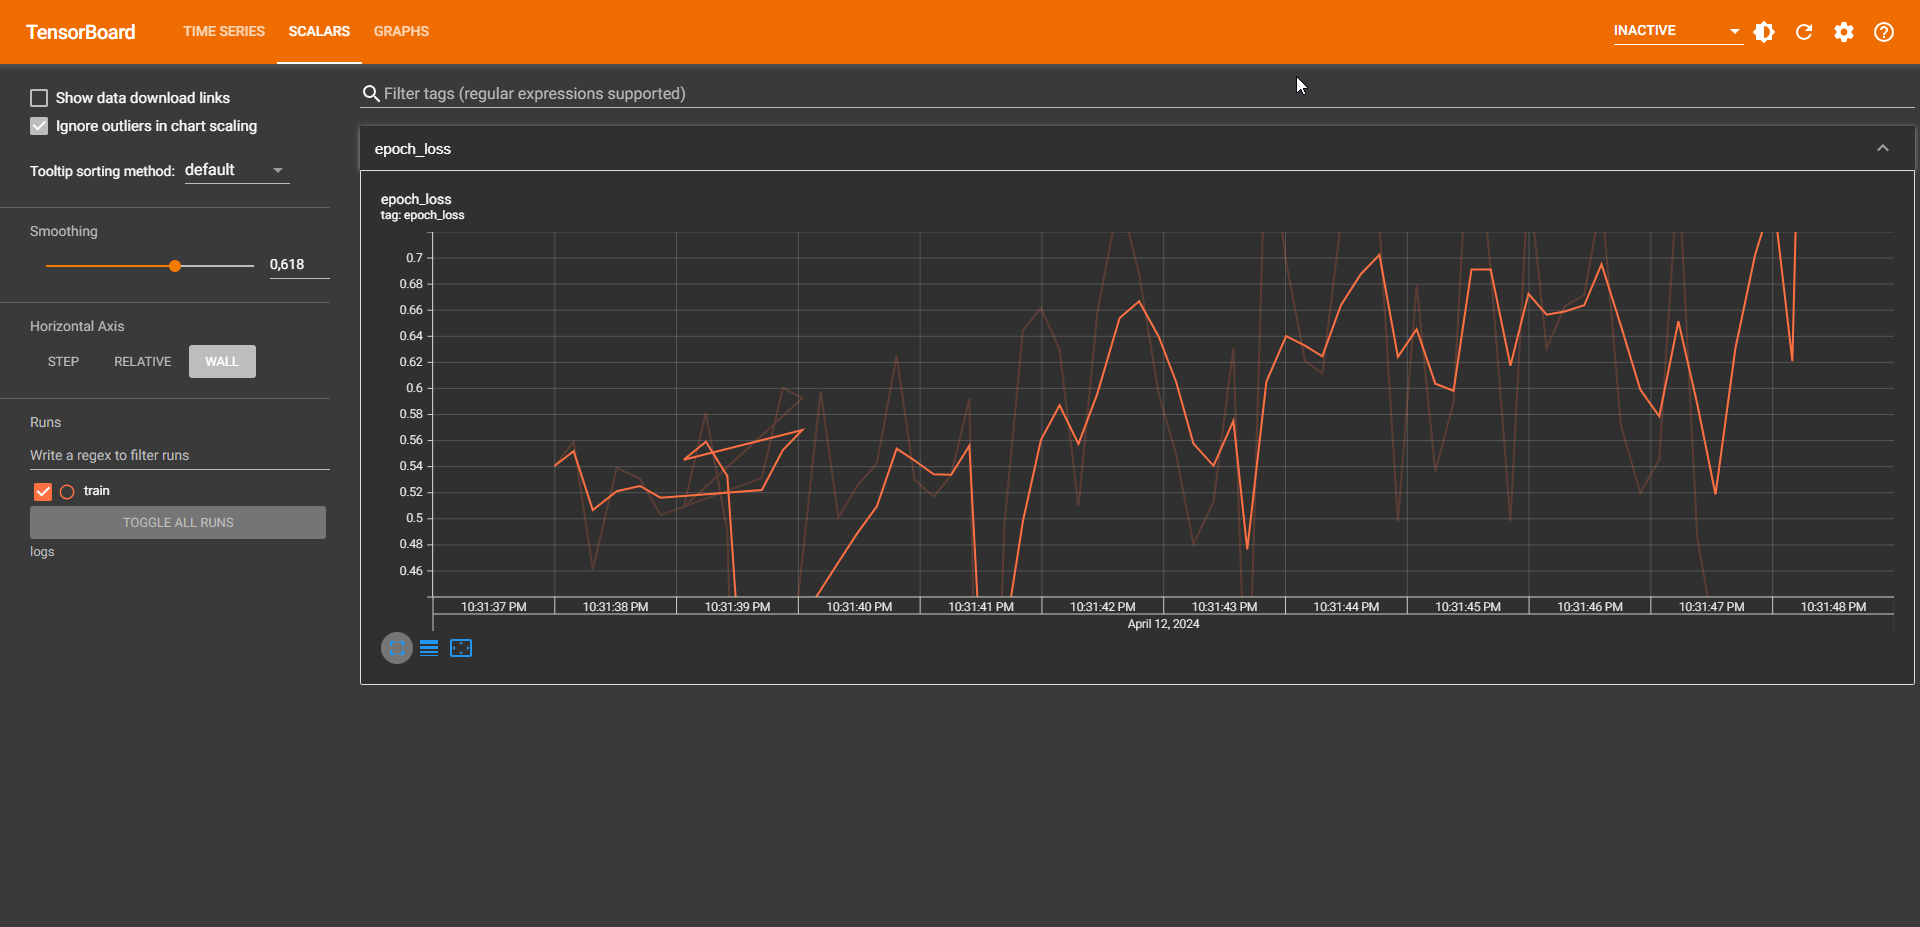

Guardamos el modelo

In [4]:
agent.model.save('model_agent_pole.h5')

c:\Users\Beatriz\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<p>Se carga el modelo previamente entrenado</p>
<p>Se simula el entorno hasta que el episodio termine (cuando la variable 'done' sea verdadera). Durante cada paso del bucle:</p>
<li>Se visualiza la simulación</li>
<li>Se decide la acción a tomar basada en la predicción del modelo</li>
<li>Se ejecuta la acción, y se obtiene el nuevo estado y la recompensa</li>
<li>Se acumula la recompensa obtenida</li>
<p>Finalmente, después de cada simulación, se cierra el entorno y se registra la recompensa total obtenida que se va mostrando cada iteración</p>

In [4]:
# Carga tu modelo
new_agent = DQLAgent(env) 
model_path = 'model_agent_pole.h5' 
new_agent.model = load_model(model_path)

times = 10

total_rewards = []

for i in range(times):
    # Configura el entorno
    env = gym.make('CartPole-v1', render_mode='human')
    state = env.reset()
    state = np.reshape(state[0], [1, 4])
    done = False
    total_reward = 0
    
    while not done:
        env.render()  # Muestra la simulación
        action = np.argmax(new_agent.model.predict(state, verbose=0)[0])  # Decide la acción
        next_state, reward, done, _, _ = env.step(action)  # Ejecuta la acción
        next_state = np.reshape(next_state, [1, 4])
        state = next_state
        total_reward += reward

    env.close()  # Cierra la ventana de la simulación
    total_rewards.append(total_reward)
    print(f"Iteración {i+1} | Recompensa obtenida: {total_reward}")

Iteración 1 | Recompensa obtenida: 25.0
Iteración 2 | Recompensa obtenida: 19.0
Iteración 3 | Recompensa obtenida: 34.0
Iteración 4 | Recompensa obtenida: 34.0
Iteración 5 | Recompensa obtenida: 20.0
Iteración 6 | Recompensa obtenida: 39.0
Iteración 7 | Recompensa obtenida: 24.0
Iteración 8 | Recompensa obtenida: 21.0
Iteración 9 | Recompensa obtenida: 22.0
Iteración 10 | Recompensa obtenida: 33.0
